$$ $$
  
<a id="contents"></a>

<center style ="font-size: xx-large; font-weight: 600; line-height: 1.1;padding: 10px">
Investigation of Distributed Image Classification with a Custom Dask Integration of a Tensorflow CNN and a Fully Dask Supported Sci-kit Learn MLP Classifier
</center>  
<center>
Group 6: Daniel Jordan, Jake Jackson, Alessandro Maria Capodaglio and Marco Lorenzetti
</center>

### Abstract:
<div style="text-align: justify; padding: 20px"> 
This project outlines the custom creation of a distributed tensorflow CNN with dask. The performances are acceptable. With acccuracies above 0.95 in just 3 epochs taking seconds to train on 4000 198x198 3 colour channel images. Similar sucess was achieved using the fully dask supported MLP classifier. Which outperformed the custom dask implimentation.
</div>

#### Key words: Dask, Sklearn,  Machine Learning, Distributed computing
----
<a id="contents"></a>

## Introduction
The project has two main concepts. The first entails the use of general dask commands to distribute the training of a tensorflow CNN. The second is the use of a dask supported scikit learn model. Dask has created a wrapper to facilitate the distribution of the scikit learn module in a professional way. The two models will be compared and contrasted. 

### Binary Image Classification
Both models will be provided with many photos that contain the face of a turtle and many photos that do not. The photos are labeled face or noface. The models must learn to distinguish between them. 

### Data / Pre-processing
The kaggle data set can be found at:  
https://www.kaggle.com/datasets/smaranjitghose/sea-turtle-face-detection  
The data set contains around 2000 images of sea turtles with their face clearly visable in the photo. Some examples are shown below.

The dataset is origionally intended for a face detection problem. Some pre-processing is required for it to suit our purpose. A csv file is provided that contains the position of boxes in the images that encloses the turtle faces. It also containes the file name of each image. This information is manipulated in a preamble() function to make face/noface image extractions easier.

The information from the preamble will be used to extract images that contain only the turtles face. Then it will be used to extract images that deffinetly do not contain a turtles face. The noface images contain a similar proportion of the origional image as the face images. This ensures the images are as similar as possible with the only difference being face or noface.

These images are ready to be placed in the TensorFlow CNN but the scikit learn module requires further preprocessing. In this preprocessing the images are grey scaled as scikit learn only supports 2D inputs. Then they are converted into hog representations. A hog is a 1D representation of the image that has colour gradient information. It facilitates easy learning for the MLP classifier.

### Chunk/Partition Size

Every distributed system has different ideal data chunk sizes. This is explored to find an ideal size for our system.

### Dashboard

The dask Dashboard has a wealth of information for performance analysis. This is used to compare the two dask ML implimentations. 

## Contents 

* [Introduction](#intro)

* [Section 1: Cloud Veneto Setup](#cloud_v) 
  * [Machines](#mach)
  * [Configuration](#conf)
  * [Maintenance](#maint)
  
* [Section 2: Image preprocessing](#img_pre)
  * [Getting the face images](#pre_face)
  * [Getting the no face images](#pre_noface)
  
* [Section 3: Custom Dask Tensorflow CNN](#cnn)
  
* [Section 4: Dask Sklearn Integration](#sklearn)
  * [Distributed loading of the turtle dataset](#data)
  * [Further Image preprocessing in dask](#futher_pre)
  * [Dask Sklearn Wrappers: MLP](#mlp)
  * [Dask Sklearn Joblib: Grid search](#grid)
  * [Dask Sklearn Joblib: Random Forest](#forest)
  * [Dask Preprocessing Performance with chunksize](#pre_perf)
  * [MLP Wrapper Performance with chunksize](#mlp_perf)

* [Section 5: Performance testing](#perf)

* [Section 6: Dashboard Analysis](#dash)


----

<a id="cloud_v"></a>
<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  

# Section 1: Cloud Veneto setup 

<a id="mach"></a>

### Machines
---
We started using small workers with 2GB of RAM each but given Ubuntu idles with a ram usage of approximately 650 mb, it makes a lot more sense to have a medium or large RAM workers with mutiple cores so the fraction of the total ram used by the os is small. 

#### Workers, Scheduler & Jupyter

* cloudveneto.medium: 2 VCPUs, RAM 4GB,  Size 25GB

If our dataset was larger it would make more sense to have a Jupyter notebook machine with more RAM but as it stands we can perform the dask compute on our data comfortably.

<a id="fs"></a>

#### File Server
* cloudveneto.large: 4 VCPUs, RAM 8GB,  Size 25GB  

Easy to mount volume if needed but not required on our project

Note: In the begining We had a difficult to find problem with the comunication of the workers due to only the default security group.

<a id="conf"></a>

### Configuration

---

We used a light weight ubuntu build, then installed miniconda we did experiemnt with lubuntu in order to try and get an even lighter os however we decided stripping the GUI out off it too involved for the purposes of this project. But condidering that and extra permormance is propergated to all the workers a lighter os would be intreasting to explore in the future.  

It's important that each dask worker uses the same set of python packages and modules when executing the code. Therefore, we made sure all the workers had identical enviroments.We experiemnted  in docker to figure out the packages needed to complete the workflow in dask. These were exported as conda enviroment yml files.  

```
conda env export > environment_X.yml
```
Installing with
```
conda env create -f environmentX.yml
```
It's also important the workers have a place they can share files between them and the jupyter machine. A ssfh server was setup via

```
sudo sshfs -o nonempty,allow_other,default_permissions,IdentityFile=/home/ubuntu/.ssh/dasktest ubuntu@10.67.22.18:/home/ubuntu/shared_remote/ /home/ubuntu/shared_local
```
Once the worker was correctly configured we created a snapshot in cloud veneto and the image was saved.

We used this image to start mutiple identical instances. 

<a id="maint"></a>

### Maintenance
---

We used paramiko to propregate setup and updates to the cluster. The example below shows an example of a simple 
```Python
import paramiko
scheduler_ip = '10.67.22.232'
workers_ip = ['10.67.22.108','10.67.22.75','10.67.22.67','10.67.22.110','10.67.22.138','10.67.22.203']

def ssh_cmd(hostname, cmd_list):
    k = paramiko.RSAKey.from_private_key_file("/home/ubuntu/.ssh/dasktest")
    c = paramiko.SSHClient()
    c.load_host_keys(filename="/home/ubuntu/.ssh/known_hosts")
    c.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    c.connect(hostname = hostname, username = "ubuntu", pkey = k)
    for command in cmd_list:
        print ("Executing {}".format( command ))
        stdin , stdout, stderr = c.exec_command(command)
        print(stdout.read())
        print( "Errors")
        print(stderr.read())
        c.close()

        
def ex_conda(cmd): #put command in through conda 
    return "source ~/miniconda3/bin/activate base; " + cmd


for worker in workers_ip:
    ssh_cmd(worker,['ls \shared_local'])
```

Issuing a command to all workers in parallel in dask

i.e clearing unallocated memory command
```Python
import ctypes
def trim_memory() -> int:
    libc = ctypes.CDLL("libc.so.6")
    return libc.malloc_trim(0)
client.run(trim_memory)
```

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="sklearn"></a> 
# Section 4: Dask Sklearn integration

In [1]:
from dask.distributed import Client
import os

client = Client('10.67.22.232:8786')
client

<Client: 'tcp://10.67.22.232:8786' processes=6 threads=6, memory=20.68 GiB>

<a id="data"></a> 
### Load all of the images into a single dask array 

In [2]:
import numpy as np
import dask_image
import dask.array as da
import dask.dataframe as dd
import dask.delayed
from dask.array.image import imread
import os


def load_turtles(path, kind='train'):
    f  = os.path.join(path, 'face/face*.jpg')
    nf = os.path.join(path, 'noface/noface*.jpg')
    
    #load all images
    images = da.concatenate([imread(f), imread(nf)])
    images=images.rechunk((40, 198,198, 3))   
    
    ##create numpy list of ,matching labels
    face_lb = np.ones(len(os.listdir(os.path.join(path, 'face')))) #fetch the 
    no_face_lb= np.negative(np.ones(len(os.listdir(os.path.join(path, 'noface')))))
    labels = np.append(face_lb, no_face_lb)
    labels= da.from_array(labels)

    return images, labels 

data_path = '/home/ubuntu/shared_local/'
X, y = load_turtles(data_path)

permutation = da.random.permutation(len(X))
X = X[permutation]
y = y[permutation]

X.persist()
y.persist()

dask.array<slice_with_int_dask_array_aggregate, shape=(4000,), dtype=float64, chunksize=(4000,), chunktype=numpy.ndarray>

### What does the data look like?
Note this is better done before the data is distributed

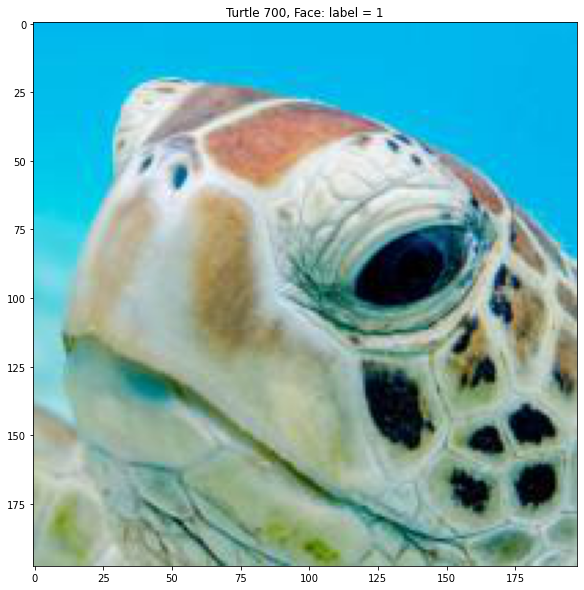

In [11]:
import matplotlib.pyplot as plt 

def plot_input(X_i, y, i):
    lb = ', No Face; label =-1'
    if y==1:
        lb=', Face: label = 1'
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
    ax.imshow(X_i)
    ax.set_title('Turtle '+ str(i)+lb)
    fig.show()


plot_input(X[700].compute(),y[700].compute(), 700)

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="futher_pre"></a> 
## Further Dask preprocessing
Sklearn will only allow the use of 2D arrays, therefore the turtle image data needs to be converted into a 2D array from the colour RGB array. To do this the image is converted to greyscale and the hog features are applied.

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
from skimage.feature import hog
import skimage

class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:

            return np.array([local_hog(img) for img in X])

### Example

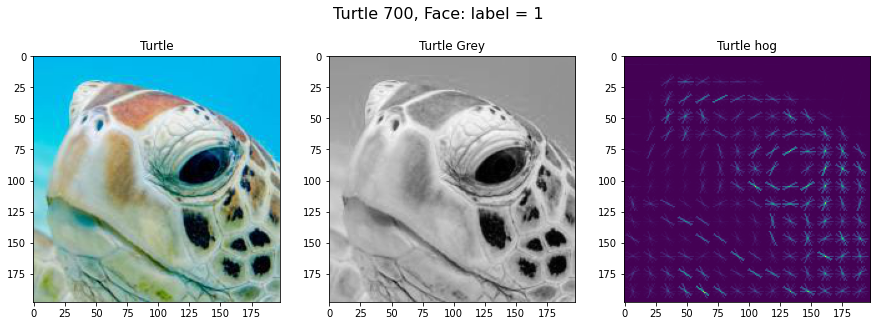

In [14]:
def plot_all_preprocessing(X_i, y_i, i): 
    #from skimage.feature import hog
    lb = ', No Face; label =-1'
    if y_i==1:
        lb=', Face: label = 1'
    turtle = X_i
    turtle_grey =  RGB2GrayTransformer().fit_transform(turtle)
    turtle_hog, turtle_hog_img = hog(
        turtle_grey, pixels_per_cell=(14,14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        visualize=True, 
        block_norm='L2-Hys')

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle('Turtle '+ str(i) +lb , fontsize=16)

    #[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]

    ax[0].imshow(turtle)
    ax[0].set_title('Turtle')
    ax[1].imshow(turtle_grey, cmap='gray')
    ax[1].set_title('Turtle')
    ax[1].imshow(turtle_grey, cmap='gray')
    ax[1].set_title('Turtle Grey')
    ax[2].imshow(turtle_hog_img)
    ax[2].set_title('Turtle hog')
    plt.show()

plot_all_preprocessing(X[700].compute(), y[700].compute(), 700)

### Bulk Preprocessing all images with Dask Delayed

In [4]:
@dask.delayed
def SGD_preprocessing_d(X):
    # create an instance of each transformer
    grayify = RGB2GrayTransformer()
    hogify = HogTransformer(
        pixels_per_cell=(14, 14), 
        cells_per_block=(2,2), 
        orientations=9, 
        block_norm='L2-Hys'
    )
    scalify = StandardScaler()
    # call fit_transform on each transform converting X_train step by step
    X_gray = grayify.fit_transform(X)
    X_hog = hogify.fit_transform(X_gray)
    X_prepared = scalify.fit_transform(X_hog)
    #return np.shape(X_prepared)
    return X_prepared

chunk_size = 500
y= y.rechunk(chunks= (chunk_size))
X_prep = X.rechunk(chunks= (chunk_size, 198,198, 3)).to_delayed().ravel()
X_prep=da.concatenate([da.from_delayed(SGD_preprocessing_d(i), (chunk_size, 6084), dtype=np.float64) for i in X_prep])

### Split training and testing

In [5]:
from IPython.display import display

m_train = int(len(X_prep)*0.6) 
m_test = len(X_prep) - m_train

##only using for unprocessed turtle plot: wouldnt keep this for serious applications
X_train_raw, X_test_raw = X[:m_train], X[m_train:]

## Processed
X_train, X_test = X_prep[:m_train], X_prep[m_train:]
y_train, y_test = y[:m_train], y[m_train:]
print('m_training = ', m_train,'m_test =', m_test,'Total data =', m_train+m_test)

X_train = X_train.persist()
y_train = y_train.persist()
X_test = X_test.persist()
y_test = y_test.persist()

display(X_train, y_train)

m_training =  2400 m_test = 1600 Total data = 4000


dask.array<getitem, shape=(2400, 6084), dtype=float64, chunksize=(500, 6084), chunktype=numpy.ndarray>

dask.array<getitem, shape=(2400,), dtype=float64, chunksize=(500,), chunktype=numpy.ndarray>

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="mlp"></a> 
## Dask Wrappers: Multi-layer Perceptron classifier.
In the case in which the data cnnot fit on one machine the processing needs to be distributed.

In [11]:
from dask_ml.wrappers import Incremental
from sklearn.neural_network import MLPRegressor, MLPClassifier
from dask.distributed import performance_report

model = MLPClassifier(
    hidden_layer_sizes=(100,50),
    activation="relu",
    solver="adam",
    learning_rate="adaptive",
    max_iter=100,
    random_state=10,
    early_stopping=False,
    verbose=1,
    tol=0.001
)

model = Incremental(model, scoring="accuracy")

with performance_report(filename="Dask_sklearn_MLP_classifier_wrapper_fit.html"):
    model.fit(X_train, y_train, classes=[-1,1])

print('N iterations',  model.n_iter_)

N iterations 5


In [8]:
with performance_report(filename="Dask_sklearn_MLP_classifier_wrapper_predict_and_score.html"):
    print(model.score(X_test, y_test))

0.99375


<a href ="#contents">
<p style="text-align: right;">return to contents</p>
</a>  
<a id="grid"></a> 

## Sklearn Joblib with  dask: GridSearch
In the case where you are fortunate to be able to fit all of the data on a single machine the joblib the .compute function can be used. The .compute method takes a collection and returns a single future. In order to use the joblib dask add-in for sklearn we computed the data to recive numpy arrays. This only works on estimators where you can specify n_jobs. 

In [40]:
from dask_ml.datasets import make_classification
from dask_ml.wrappers import Incremental
from sklearn.linear_model import SGDClassifier

X_train = X_train.rechunk(chunks= (400, 6084))
y_train = y_train.rechunk(chunks= (400))

##maybe rechunck the test
X_train = X_train.compute()
X_test_raw = X_test_raw.compute()
y_train = y_train.compute()
X_test = X_test.compute()
y_test = y_test.compute()

 ### Imports

In [41]:
import numpy as np
from dask.distributed import Client
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

### Run

In [22]:
param_space = {
    'C': np.logspace(-6, 6, 13),
    'gamma': np.logspace(-8, 8, 17),
    'tol': np.logspace(-4, -1, 4),
    'class_weight': [None, 'balanced'],
}

model = SVC(kernel='rbf')
search = RandomizedSearchCV(model, param_space, cv=3, n_iter=50, verbose=10)

with joblib.parallel_backend('dask'):
    search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


### Results

In [23]:
search.best_score_

0.9966666666666667

In [24]:
search.best_params_

{'tol': 0.001, 'gamma': 0.0001, 'class_weight': 'balanced', 'C': 1000000.0}

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="forest"></a> 

## Sklearn Joblib with  dask: Random forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0)

with joblib.parallel_backend('dask'):
    clf.fit(X_train, y_train)
    
clf.score(X_test, y_test)

0.98875

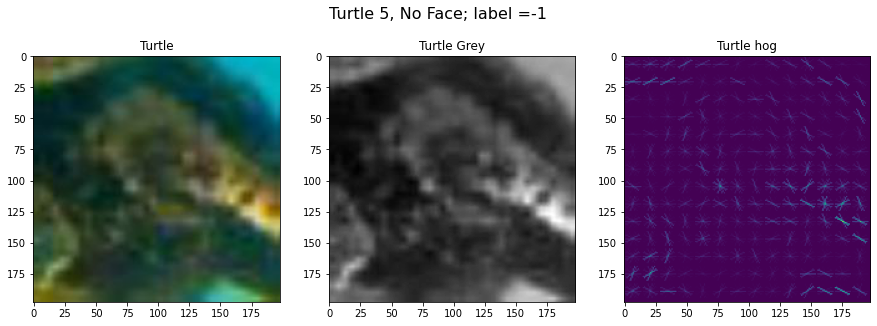

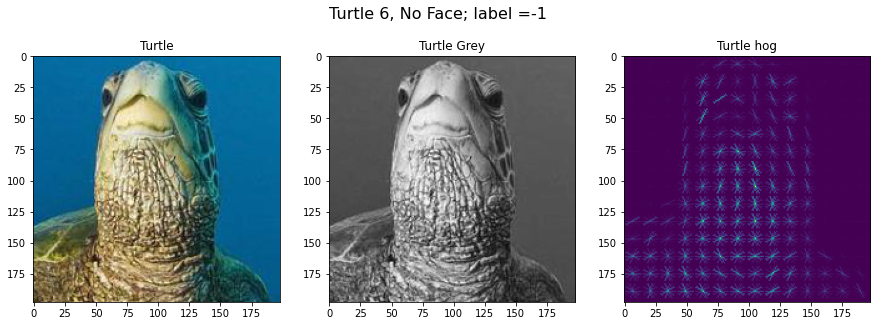

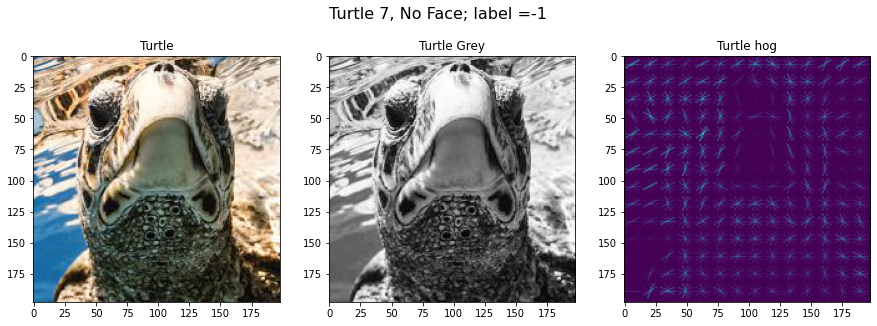

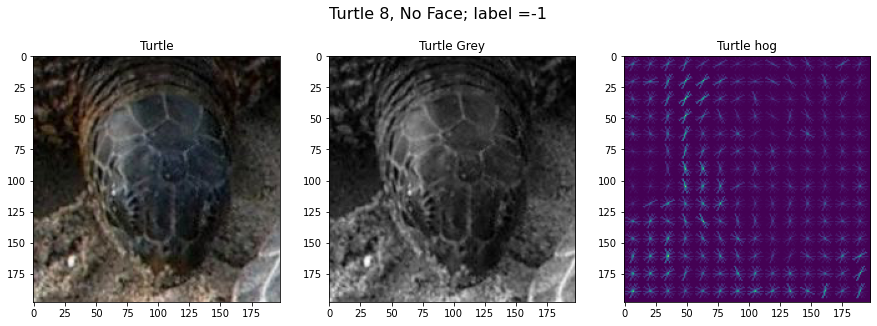

[None, None, None, None]

In [44]:
y_pred=clf.predict(X_test)
X_fails=X_test_raw[y_pred!=y_test]
y_fails=y_pred[y_pred!=y_test]
import matplotlib.pyplot as plt 
def plot_all_preprocessing(X_i, y_i, i): 
    #from skimage.feature import hog
    lb = ', No Face; label =-1'
    if y_i==1:
        lb=', Face: label = 1'
    turtle = X_i
    turtle_grey =  RGB2GrayTransformer().fit_transform(turtle)
    turtle_hog, turtle_hog_img = hog(
        turtle_grey, pixels_per_cell=(14,14), 
        cells_per_block=(2, 2), 
        orientations=9, 
        visualize=True, 
        block_norm='L2-Hys')

    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle('Turtle '+ str(i) +lb , fontsize=16)

    #[a.tick_params(bottom=False, left=False, labelbottom=False, labelleft=False) for a in ax]

    ax[0].imshow(turtle)
    ax[0].set_title('Turtle')
    ax[1].imshow(turtle_grey, cmap='gray')
    ax[1].set_title('Turtle')
    ax[1].imshow(turtle_grey, cmap='gray')
    ax[1].set_title('Turtle Grey')
    ax[2].imshow(turtle_hog_img)
    ax[2].set_title('Turtle hog')
    plt.show()

##plot 5 fails to illustrate 
[plot_all_preprocessing(X_fails[i], y_fails[i], i) for i in range(5, 9)] 

<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
<a id="pre_perf"></a> 
## Preprocessing Performance with Chunksize Test

In [18]:
client.restart()
X, y = load_turtles(data_path)

permutation = da.random.permutation(len(X))
X = X[permutation]
y = y[permutation]

X.persist()
y.persist()

dask.array<slice_with_int_dask_array_aggregate, shape=(4000,), dtype=float64, chunksize=(4000,), chunktype=numpy.ndarray>

## With rechuncking

In [45]:
def chunk_test(funct, d_arr, chunk_sizes= [400,1000], n_iter=3, output_size = True, dtype=np.float64):
    if output_size: ##default output and input the same
        output_size=da.shape(d_arr)
    
    from dask.distributed import wait
    import time
    chunk = da.shape(d_arr)
    means=np.zeros(len(chunk_sizes)); stds =means #just initalises same

    def run_n_time(funct, d_arr, chunk, output):
        d_arr = d_arr.rechunk(chunks= chunk).to_delayed().ravel()
        d_arr = da.concatenate([da.from_delayed(funct(i), output_size, dtype=dtype) for i in d_arr])
        t1 = time.perf_counter()
        wait(d_arr.persist())
        t2 = time.perf_counter()
        return t2-t1 
    i=0
    for size in chunk_sizes:
        output =(size, *output_size)
        chunk = (size, *chunk[1:])  
        times = np.array([run_n_time(funct, d_arr, chunk, output)  for n in range(0,n_iter)])
        means[i]  = np.mean(times)
        stds[i]   = np.std(times)
        i+=1
        print('Chunk = ', i)
        
    means = means*1000
    stds = stds*1000
    return means, stds

n_workers = len(client.scheduler_info()['workers'].keys())
print("N workers = ", n_workers)
n_im = 4000
tasks=np.arange(1,22)*n_workers
chunk_size= n_im/tasks
chunk_sizes=np.sort(np.round(chunk_size))

n_iter=3
times, std = chunk_test(SGD_preprocessing_d, X, chunk_sizes=chunk_sizes, n_iter=n_iter, output_size=[6084])

Chunk =  1
Chunk =  2
Chunk =  3
Chunk =  4
Chunk =  5
Chunk =  6
Chunk =  7
Chunk =  8
Chunk =  9
Chunk =  10
Chunk =  11
Chunk =  12
Chunk =  13
Chunk =  14
Chunk =  15
Chunk =  16
Chunk =  17
Chunk =  18
Chunk =  19
Chunk =  20
Chunk =  21


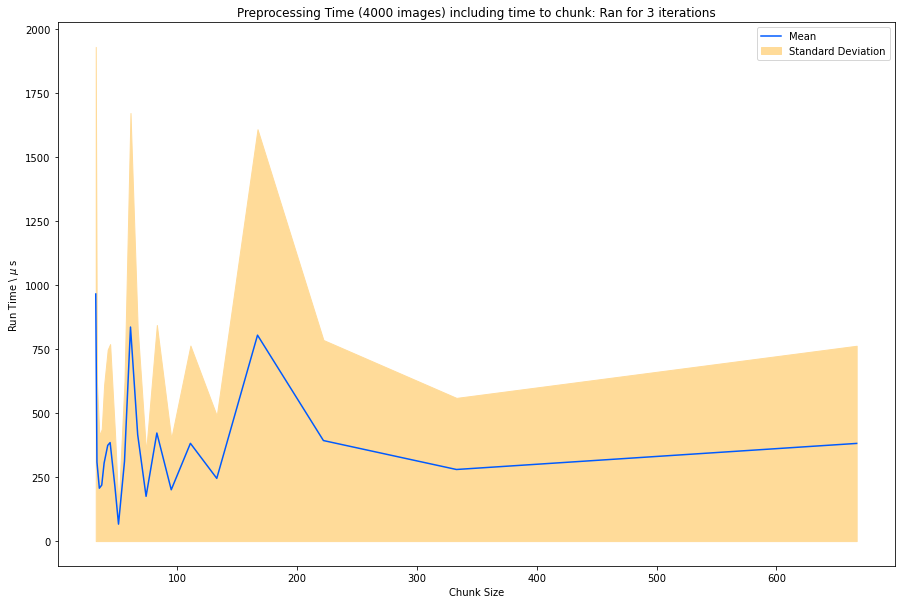

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(chunk_sizes, times, label = "Mean", color='#005AFF')
plt.fill_between(chunk_sizes,times+std,times-std, label='Standard Deviation', color='#ffdb99')
plt.xlabel('Chunk Size')
plt.ylabel('Run Time \ $\mu$ s')
plt.title('Preprocessing Time (4000 images) including time to chunk: Ran for ' + str(n)+' iterations' )
plt.legend()

## Without timing rechunking

In [39]:
def chunk_test(funct, d_arr, chunk_sizes= [400,1000], n_iter=3, output_size = True, dtype=np.float64):
    if output_size: ##defult output and input the same
        output_size=da.shape(d_arr)
    
    from dask.distributed import wait
    import time
    chunk = da.shape(d_arr)
    means=np.zeros(len(chunk_sizes)); stds =means #just initalises same

    def run_n_time(funct, d_arr, chunk, output):
        d_arr = d_arr.rechunk(chunks= chunk)
        wait(d_arr.persist())
        
        d_arr = d_arr.to_delayed().ravel()
        d_arr = da.concatenate([da.from_delayed(funct(i), output_size, dtype=dtype) for i in d_arr])
        t1 = time.perf_counter()
        wait(d_arr.persist())
        t2 = time.perf_counter()
        return t2-t1 
    i=0
    for size in chunk_sizes:
        output =(size, *output_size)
        chunk = (size, *chunk[1:])  
        times = np.array([run_n_time(funct, d_arr, chunk, output)  for n in range(0,n_iter)])
        means[i]  = np.mean(times) # np will convert
        stds[i]   = np.std(times)
        i+=1
        print('Chunk = ', i)
        
    means = means*1000
    stds = stds*1000
    return means, stds

n_workers = len(client.scheduler_info()['workers'].keys())
print("N workers = ", n_workers)
n_im = 4000
tasks=np.arange(1,22)*n_workers
chunk_size= n_im/tasks
chunk_sizes=np.sort(np.round(chunk_size))
n_iter=3
times2, std2 = chunk_test(SGD_preprocessing_d, X, chunk_sizes=chunk_sizes, n_iter=n_iter, output_size=[6084])

N workers =  6
Chunk =  1
Chunk =  2
Chunk =  3
Chunk =  4
Chunk =  5
Chunk =  6
Chunk =  7
Chunk =  8
Chunk =  9
Chunk =  10
Chunk =  11
Chunk =  12
Chunk =  13
Chunk =  14
Chunk =  15
Chunk =  16
Chunk =  17
Chunk =  18
Chunk =  19
Chunk =  20
Chunk =  21


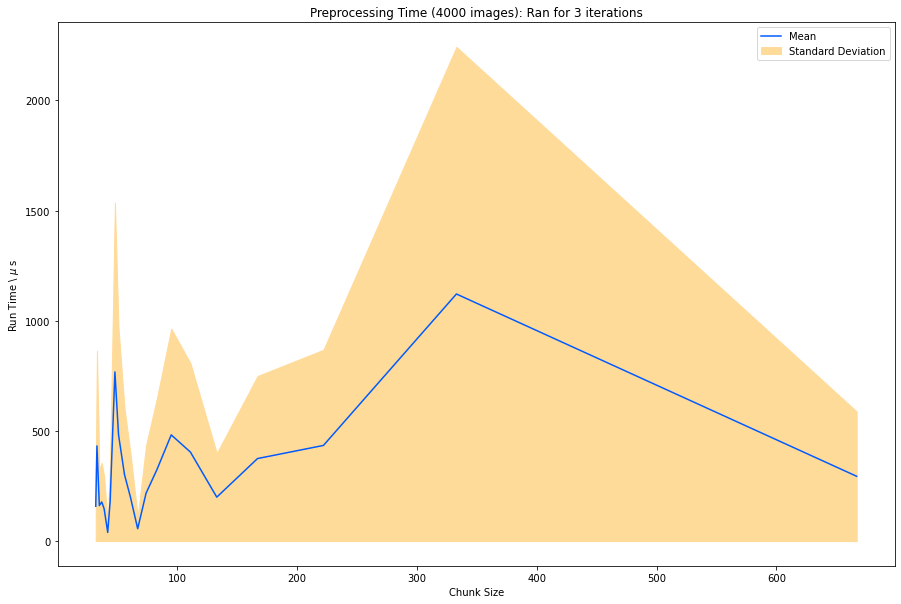

In [55]:
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(chunk_sizes, times2, label = "Mean", color='#005AFF')
plt.fill_between(chunk_sizes,times2+std2,times2-std2, label='Standard Deviation', color='#ffdb99')
plt.xlabel('Chunk Size')
plt.ylabel('Run Time \ $\mu$ s')
plt.title('Preprocessing Time (4000 images): Ran for ' + str(n)+' iterations' )
plt.legend()

<a id="mlp_perf"></a>
<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  
## MLP Wrapper Performance with chunksize

In [25]:
def mlp_performance(X_arr, y_arr, chunk_sizes= [400,1000], n_iter=3):
    from dask.distributed import wait
    import time
    
    chunk_X = da.shape(X_arr)
    chunk_y = da.shape(y_arr)
    means=np.zeros(len(chunk_sizes)); stds =means #just initalises same

    model = MLPClassifier(
        hidden_layer_sizes=(100,50),
        activation="relu",
        solver="adam",
        learning_rate="adaptive",
        max_iter=100,
        random_state=10,
        early_stopping=False,
        verbose=1,
        tol=0.001
    )

    model = Incremental(model, scoring="accuracy")

    def run_n_time(X_arr, y_arr, chunk_X, chunk_y):        
        X_arr = X_arr.rechunk(chunks= chunk_X)
        y_arr = y_arr.rechunk(chunks= chunk_y)
        wait(X_arr.persist())
        wait(y_arr.persist())

        t1 = time.perf_counter()
        model.fit(X_arr, y_arr, classes=[-1,1])
        t2 = time.perf_counter()
        return t2-t1 
    i=0
    for size in chunk_sizes:
        chunk_X = (size, *chunk_X[1:])
        chunk_y = (size, *chunk_y[1:])
        times = np.array([run_n_time(X_arr, y_arr, chunk_X, chunk_y)  for n in range(0,n_iter)])
        means[i]  = np.mean(times)
        stds[i]   = np.std(times)
        i+=1
        print('Chunk = ', i)
    return means, stds

n_workers = len(client.scheduler_info()['workers'].keys())
n_im = 4000
tasks=np.arange(1,22)*n_workers
chunk_size= n_im/tasks
chunk_size=np.sort(np.round(chunk_size))
n_iter = 3

mlp_times, mlp_stds= mlp_performance(X_train, y_train, chunk_sizes= chunk_size, n_iter=n_iter)

Chunk =  1
Chunk =  2
Chunk =  3
Chunk =  4
Chunk =  5
Chunk =  6
Chunk =  7
Chunk =  8
Chunk =  9
Chunk =  10
Chunk =  11
Chunk =  12
Chunk =  13
Chunk =  14
Chunk =  15
Chunk =  16
Chunk =  17
Chunk =  18
Chunk =  19
Chunk =  20
Chunk =  21


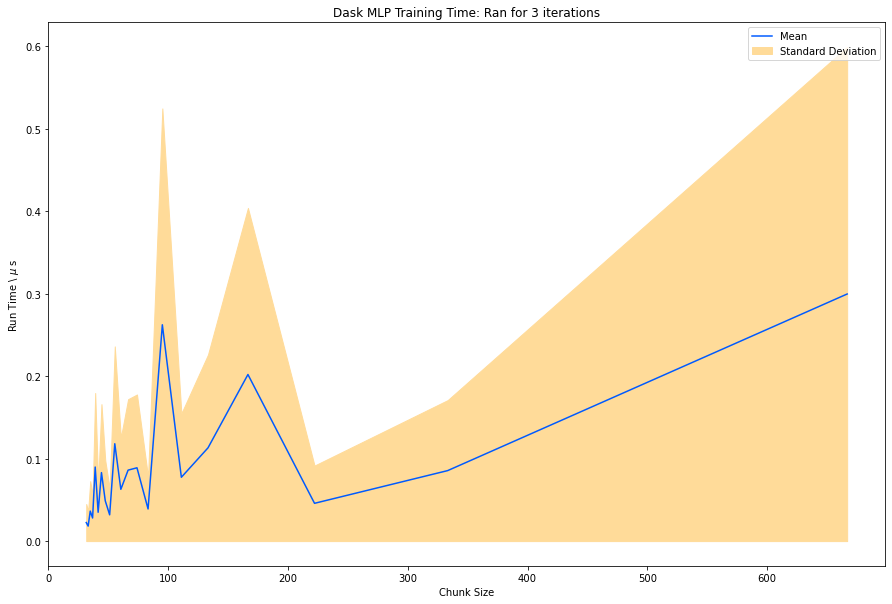

In [35]:
import matplotlib.pyplot as plt
n_iter=3
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
plt.plot(chunk_size, mlp_times, label = "Mean", color='#005AFF')
plt.fill_between(chunk_size, mlp_times+mlp_stds, mlp_times-mlp_stds, label='Standard Deviation', color='#ffdb99')
plt.xlabel('Chunk Size')
plt.ylabel('Run Time \ $\mu$ s')
plt.title('Dask MLP Training Time: Ran for ' + str(n_iter)+' iterations' )
plt.legend()

<a id="perf"></a>
<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  

# Section 5: Performance testing

## Partition/Chunk Tests

The way in which the data is chunked is important for performance.

- Balanced Chunks: The number of chunks need to be distributed evenly among the workers. If there is an imbalance then at the end of every process the remainder need to be processed by one worker. This can significantly affect run times.

- Ram Limit: If the memory size of the chunks approaces the size of the workers ram this can significantly reduce the procesing time. 

The various functions we have outlined will be tested for the ideal chunk size. To do this the data will be rechunked, persisted and then placed into the function. The run times will be measured for the various chunk sizes.

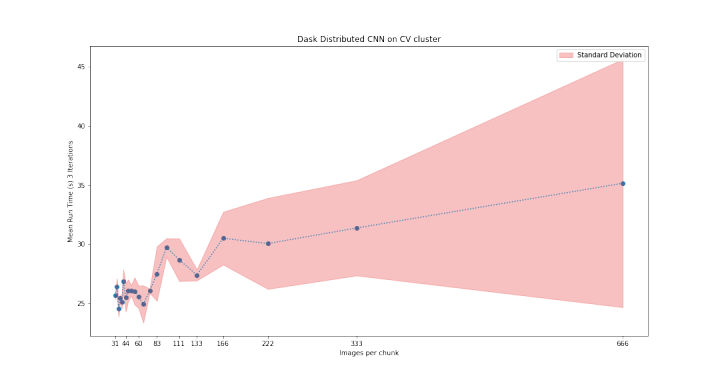

In [1]:
# import image module
from IPython.display import Image
Image("/home/ubuntu/daskdistributedCNN.png")

<a id="cloud_v"></a>
<a href ="#contents"><p style="text-align: right;">return to contents</p></a>  

## Section 6: Dask dashboard our distributed CNN vs Sklearn implemented algorithm

### Task Stream

Distributed CNN

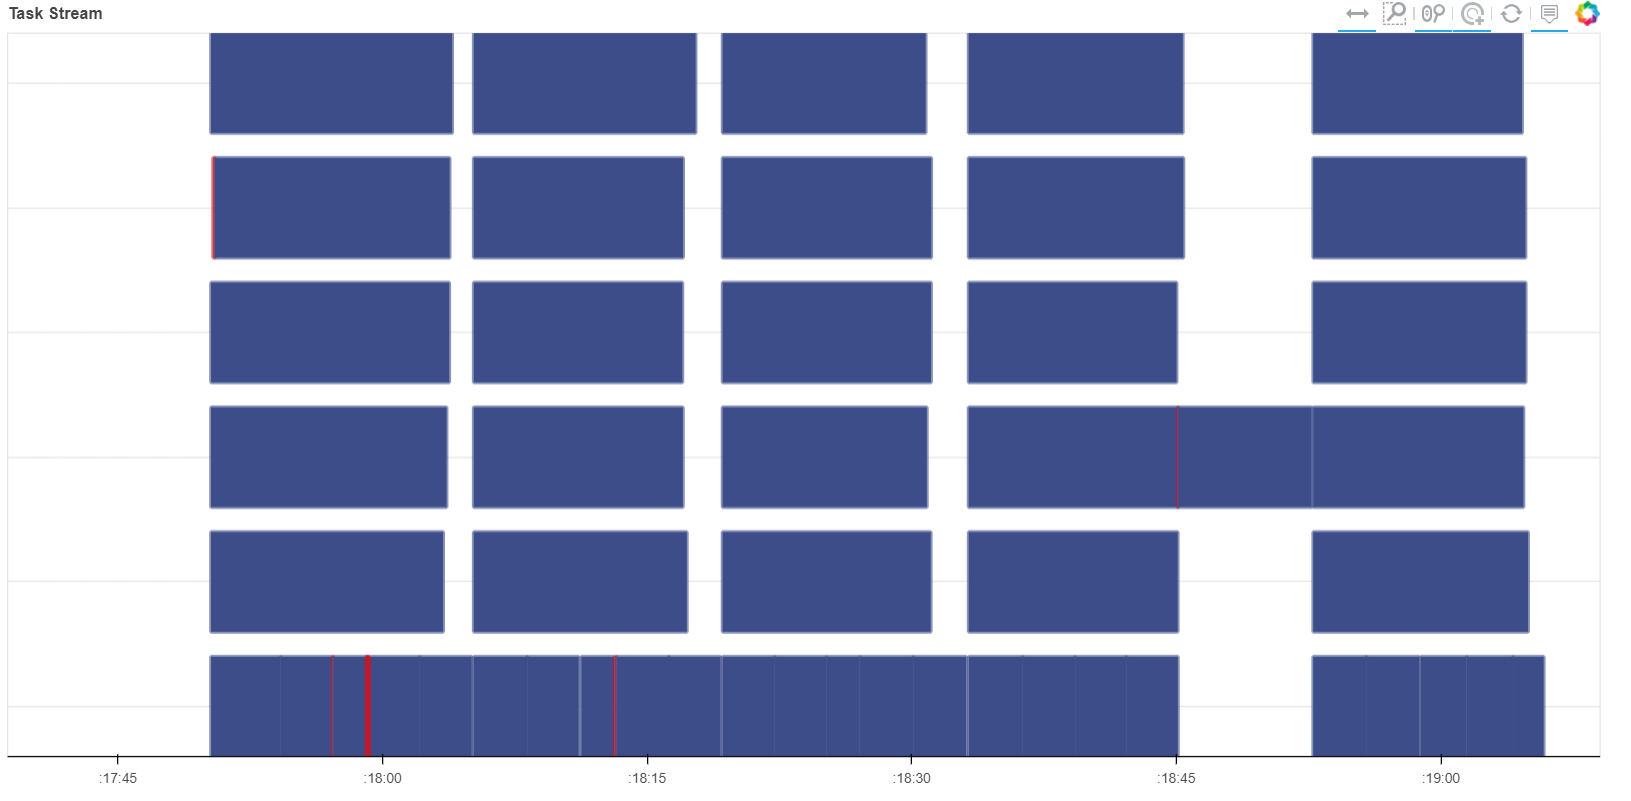

In [11]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\taskCNN.png")

SKLearn

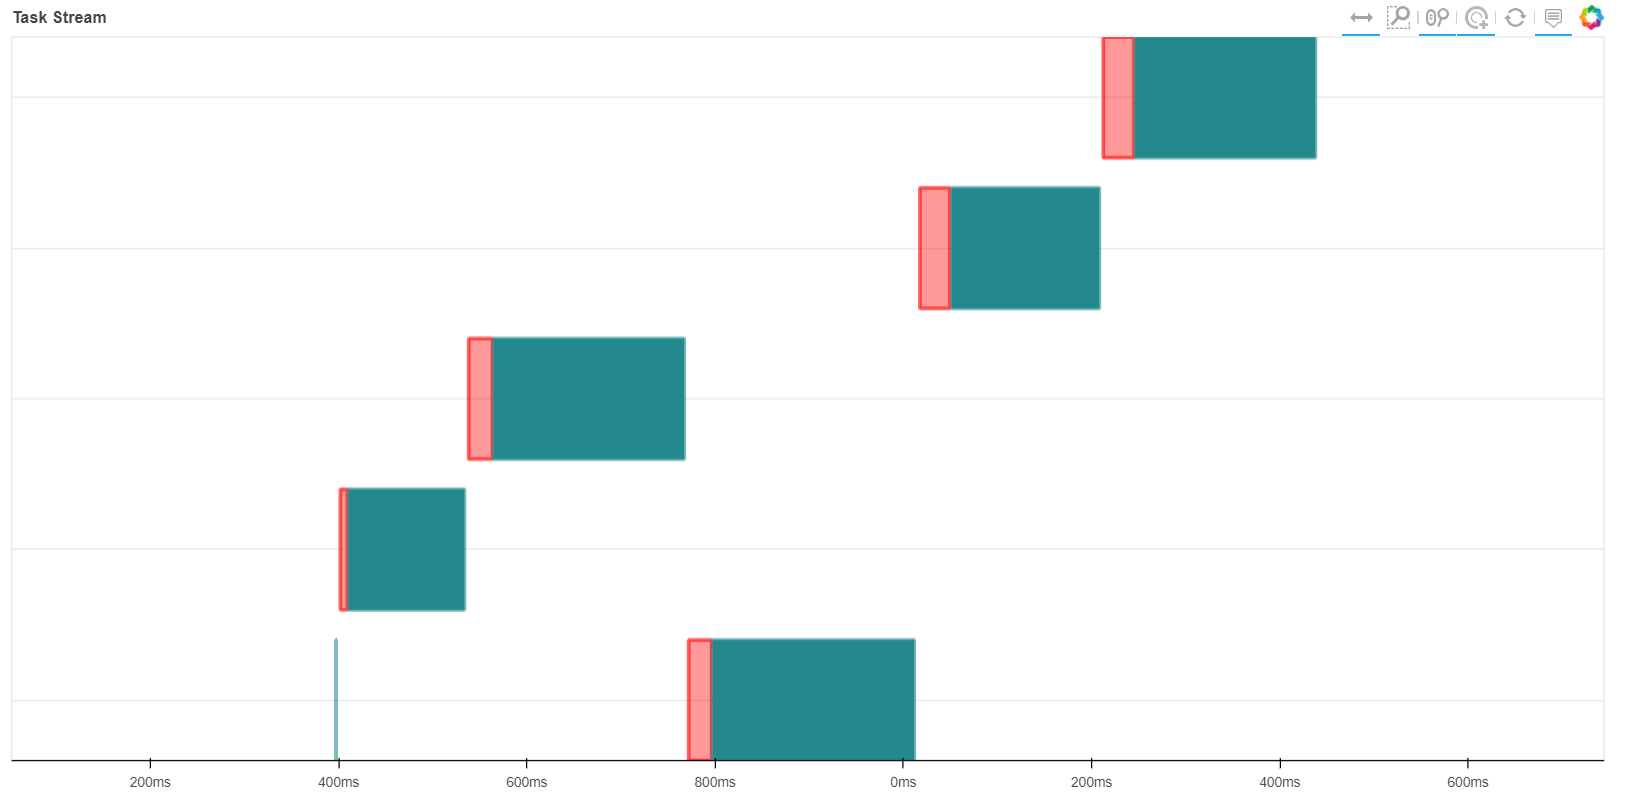

In [12]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\taskSK.png")

### Memory and CPU Usage

Distributed CNN

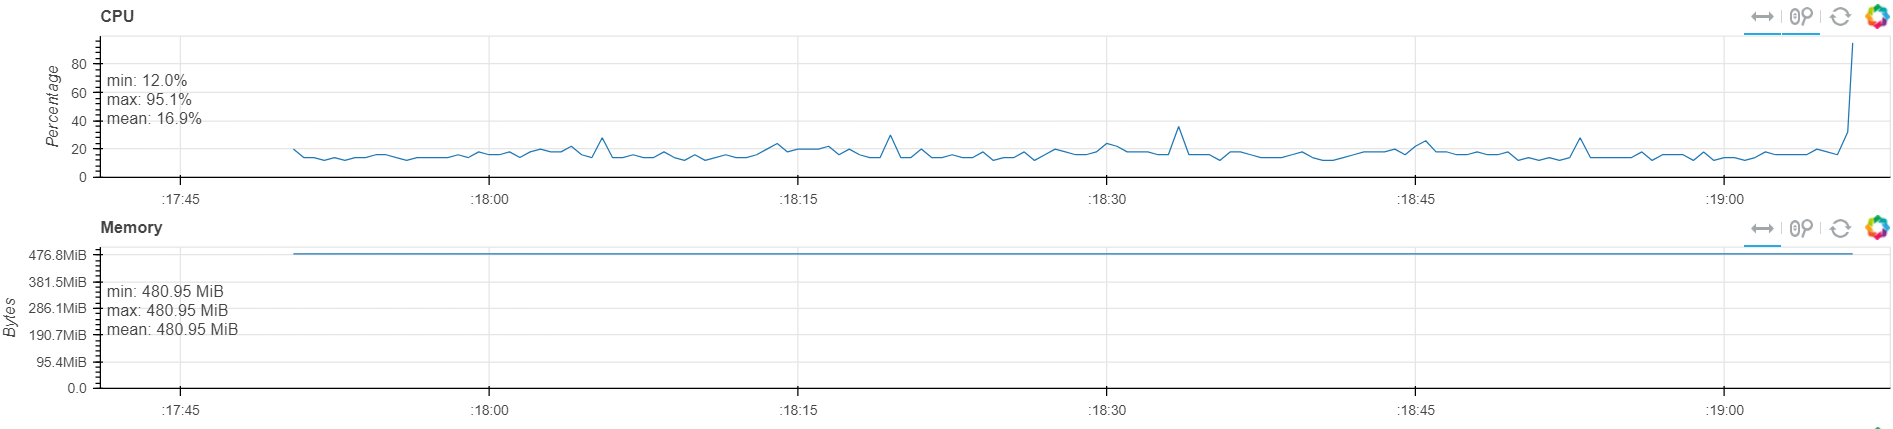

In [15]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\UsageCNN.png")

SKLearn

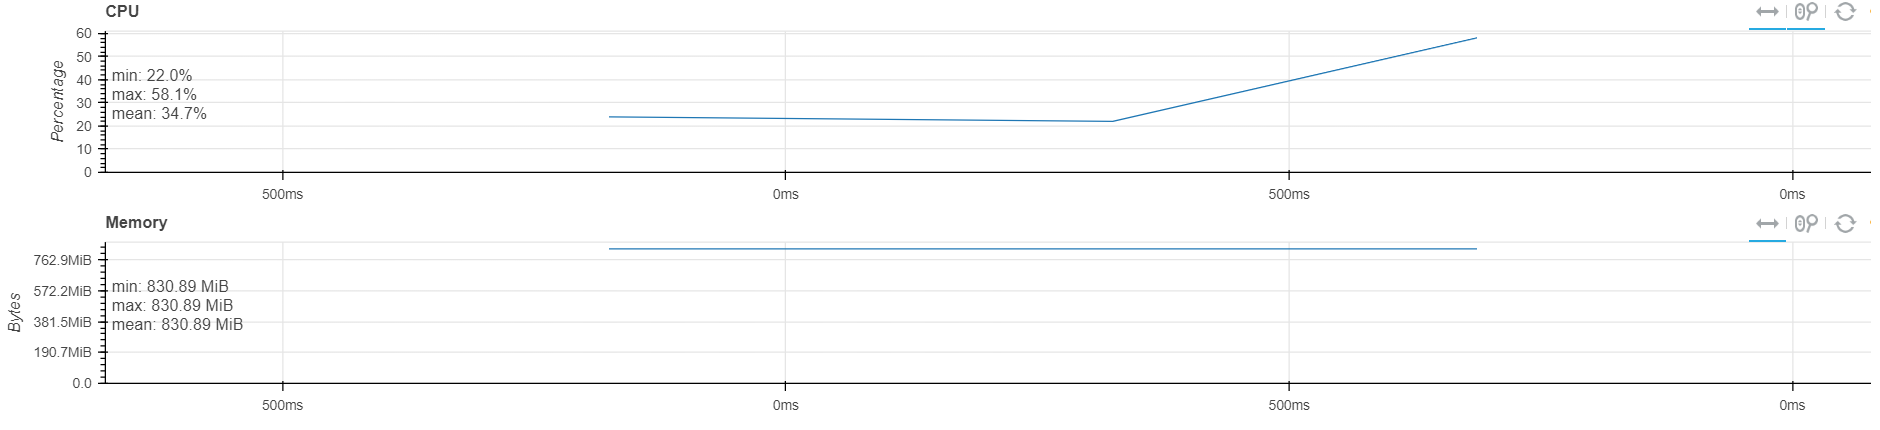

In [13]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\UsageCSK.png")

### Worker Profile

CNN

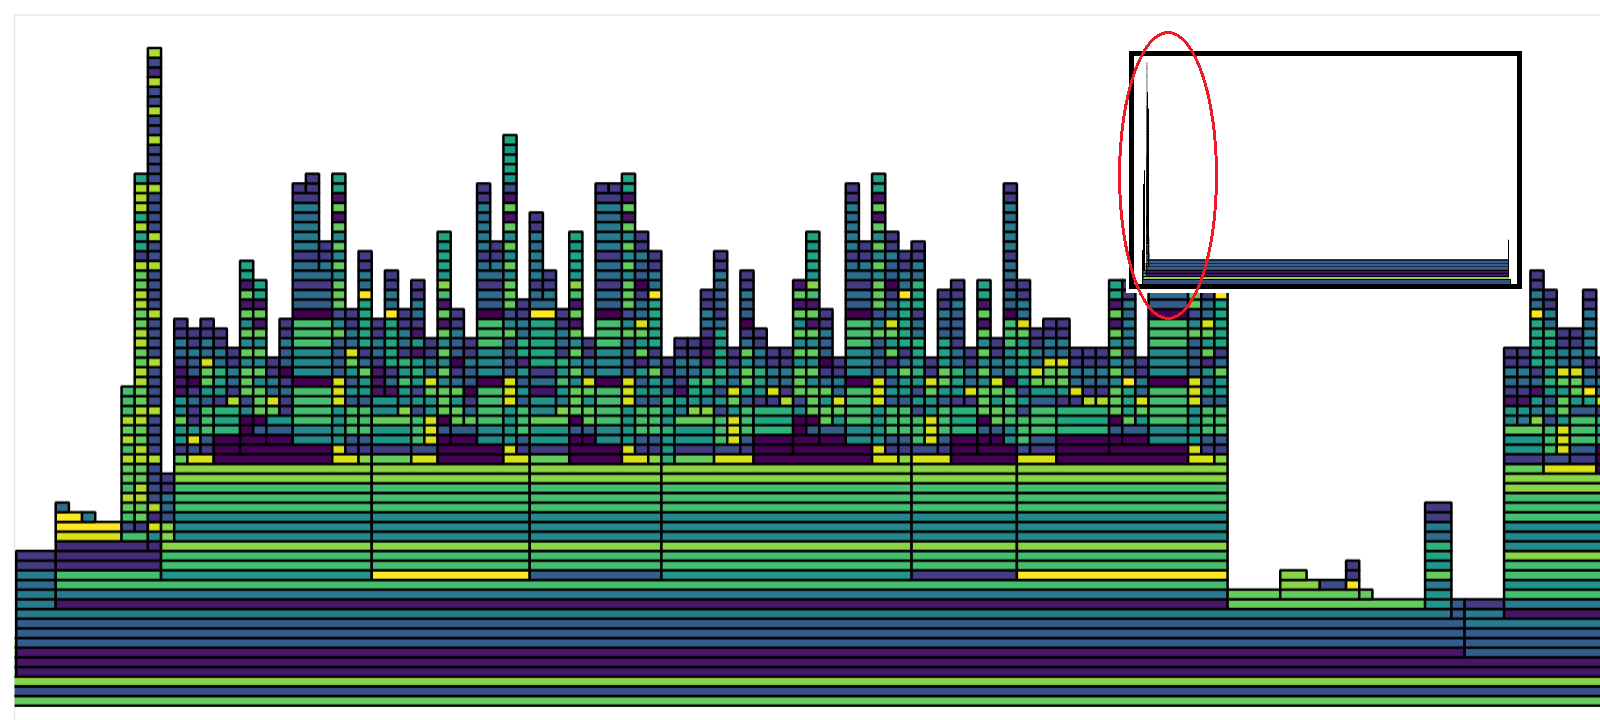

In [3]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\zoomCNN_W.png")

SKLearn

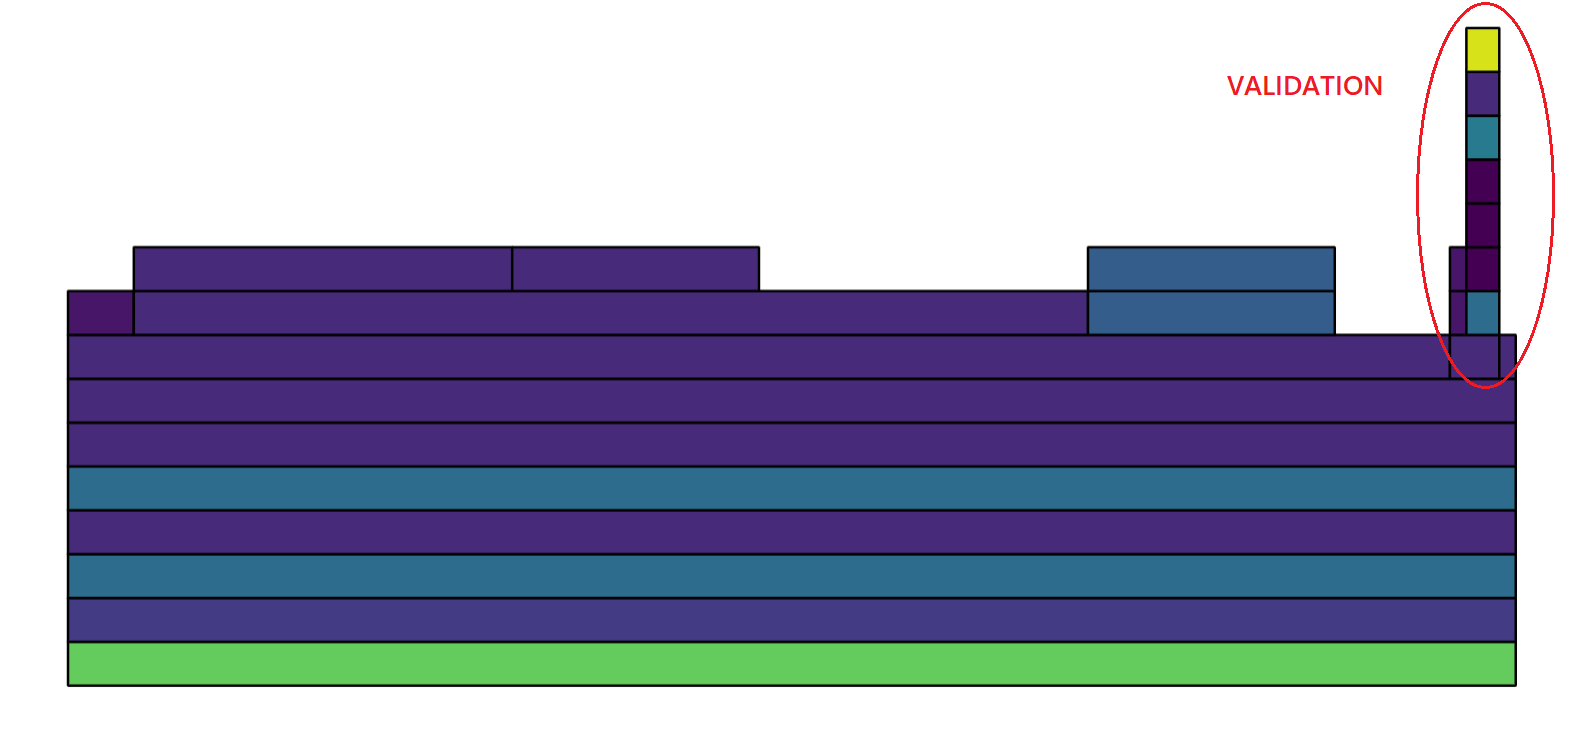

In [4]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\SK_W.png")

### Bandwidth

Distributed CNN

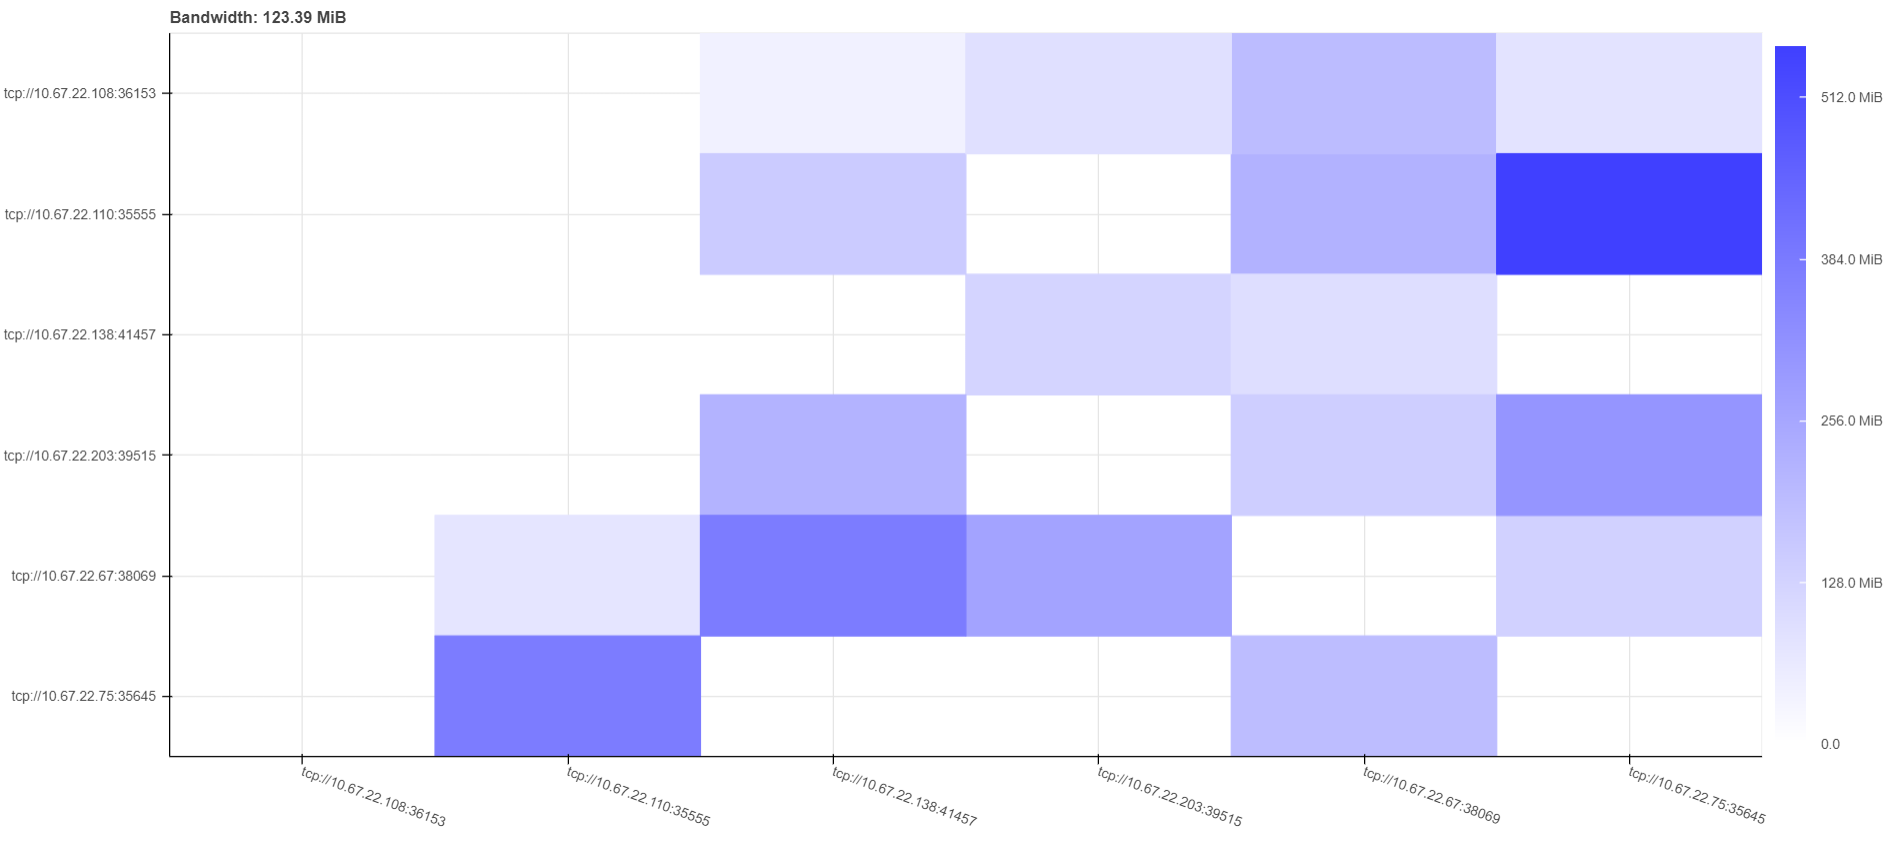

In [16]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\BandwidthCNN.png")

SKLearn

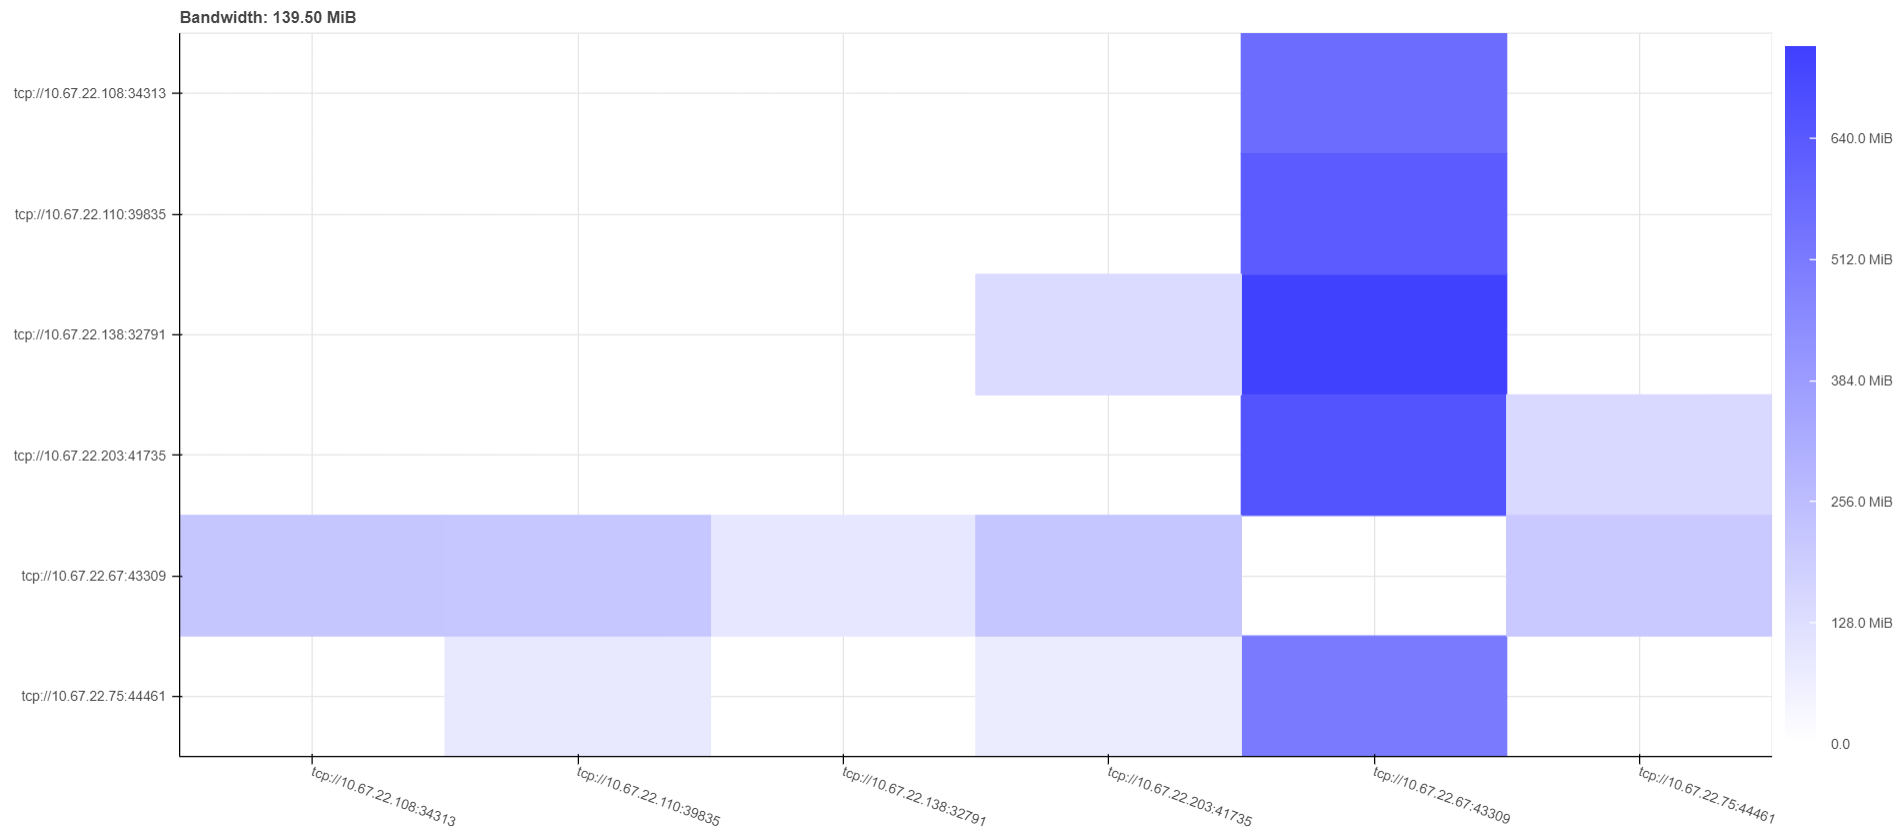

In [17]:
Image(r"C:\Users\Marco\Desktop\mapd\pic\BandwidthSK.png")


## Dashboard  Videos

The memory use was not recorded in the dashboard html file. Therfore in each of the machine learning model was ran and screen captured, after 5 seconds after completion the unmanged memory was trimmed. 

### MLP Wrapper Test

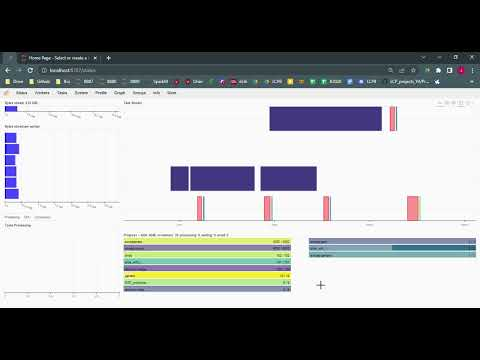

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('T_5azs2XD04', width=1000, height=500)

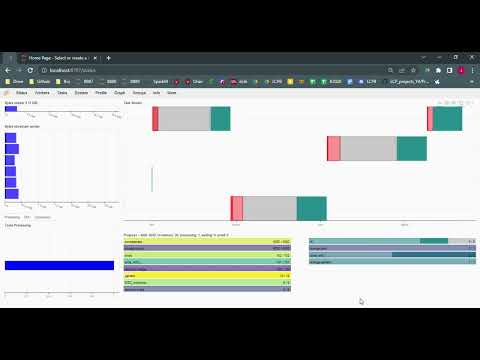

In [2]:
YouTubeVideo('CFUaPw8fUPw', width=1000, height=500)

### Custom Dask Tensorflow CNN

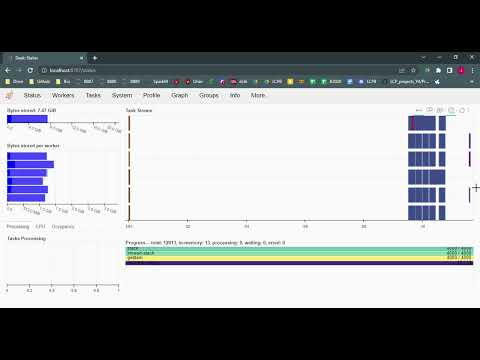

In [3]:
YouTubeVideo('zVw-95Xnj7g', width=1000, height=500)

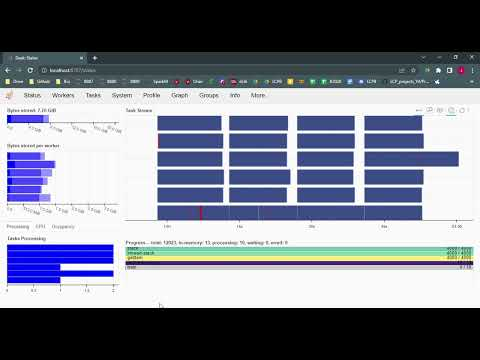

In [4]:
YouTubeVideo('t6cprUu1olM', width=1000, height=500)